### Repo Link: https://github.com/BenVerst/BenVerst-Air-Quality-Data-False-Color-Image

![Thomas Fire Aftermath](figures/thomas_fire_after.png)

## About

The Thomas Fire, a destructive wildfire that unfolded in December 2017, struck Ventura County, California. It ignited near Santa Paula, the fire quickly gained momentum, fueled by powerful Santa Ana winds and dry environmental conditions. This formidable combination led to the rapid spread of the flames, ultimately encompassing over 281,000 acres, making it one of the largest wildfires in California's history. Communities, including the city of Ventura, faced widespread evacuations as the fire approached populated areas, causing significant destruction with the loss of numerous homes and structures. Firefighters tirelessly battled the blaze amid challenging conditions, and it took several weeks to achieve full containment by January 12, 2018. The Thomas Fire prompted critical discussions about the increasing threat of wildfires in California and the necessity for enhanced firefighting and prevention strategies.

## Purpose
The purpose of this notebook is to create a graph of the Air Quality Data in Santa Barbara, CA over time. The other goal is to create a false color image showing the fire scar of the Thomas fire in 2017. The reason for these maps is so we can compare them to see when and how the Thomas fire affected Santa Barbara.


## Highlights
- Data tidying using `pandas` and `geopandas`
- Visualizing data
- Comparing data
- Statistical analysis

## Data

1. [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) from the [US Environmental Protection Agency](https://www.epa.gov) website. This data will be used to visualize the impact on the AQI of the 2017 Thomas Fire in Santa Barbara County.

2. A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the [Landsat Collection 2 Surface Reflectance](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance), collected by the Landsat 8 satellite. The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)). Data should be used for visualization purposes only.

3. A shapefile of the fire perimeters in California during 2017. The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

## Import Libraries and Functions

In [27]:
import os
import numpy as np
import pandas as pd

import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.patches as mpatches
from matplotlib.markers import MarkerStyle

from shapely import Point
from shapely import Polygon
from shapely import box
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

### Import and Read Data

In [28]:
# read in the air data using link
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

# read in fire dataset
# create path
ca_bands = os.path.join(os.getcwd(),'Air-Quality-Data-False-Color-Image', 'data', 'landsat8-2018-01-26-sb-simplified.nc')

# read in data using path
ca_fire_bands_2017 = rioxr.open_rasterio(ca_bands)

# read in CA perimeter dataset
ca_fire_perimeter_2017= gpd.read_file(os.path.join(os.getcwd(),'Air-Quality-Data-False-Color-Image', 'data', 'California_Fire_Perimeters_2017', 'California_Fire_Perimeters_2017.shp'))

# Air Quality Index

### Data Exploration

In [29]:
# looks at the top 5 rows of the aqi_17 data frame
aqi_17.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1


In [30]:
# looks at the top 5 rows of the aqi_18 data frame
aqi_18.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2018-01-02,32,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2018-01-05,34,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2018-01-08,15,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2018-01-11,19,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2018-01-14,25,Good,PM2.5,01-003-0010,1


### Merge `aqi-17` and `aqi_18` Datasets

In [31]:
# "glues together" the two data frames.
aqi = pd.concat([aqi_17, aqi_18])

### Update Columns

In [32]:
# re-assign the column names
aqi.columns = aqi.columns.str.lower()

# re-assign the column names again
aqi.columns = aqi.columns.str.replace(' ','_')

We can adjust the scale used for plotting the bands to get a true color image. 
> The issue here is the clouds: their RGB values are outliers and cause the other values to be squished when plotting. 

### Filter Data

In [33]:
# filters for only Santa Barbara
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

# removes the state name, county name, state code, and county code
aqi_sb = aqi_sb.drop(columns=['state_name','county_name','state_code','county_code'])


### Change Datatype

In [34]:
# Updates the date column type to datetime object
aqi_sb.date = pd.to_datetime(aqi_sb.date)


### Update Index

In [35]:
# Updates the index of aqi_sb
aqi_sb = aqi_sb.set_index('date')


## Data Analysis

### Create A Rolling Mean

In [36]:
# adds the mean of the AQI over a 5-day rolling window to the aqi_sb dataframe
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

## AQI Plot

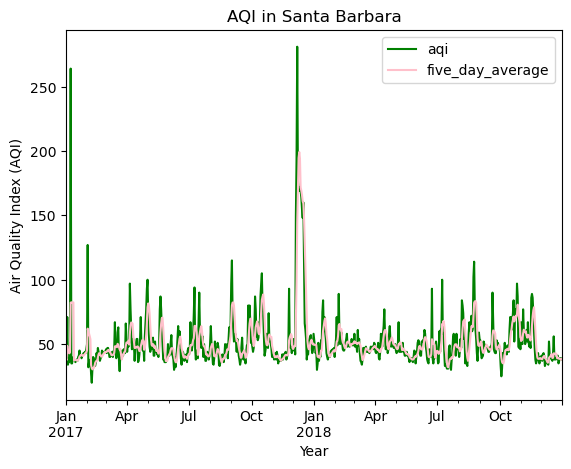

In [37]:
aqi_sb.plot(y = ['aqi', 'five_day_average'], #plot aqi and five_day_average
           title = 'AQI in Santa Barbara', #adds title
           xlabel = 'Year', #adds x label
           ylabel = 'Air Quality Index (AQI)', #adds y label
           color = {'aqi': 'green', #adds color to aqi
                    'five_day_average': 'pink' #add pink to five_day_average
                   }
           )

# save plot into folder
plt.savefig('Air-Quality-Data-False-Color-Image/figures/aqi.png', bbox_inches='tight',  dpi=50)

Around December 2017, There was a large AQI spike in both daily and 5 day average. This was probably due to a fire at the beginning of that year.

# False Color Image

### Data Exploration

In [38]:
# looks at data
ca_fire_bands_2017

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

In [39]:
# looks at head of data
ca_fire_perimeter_2017.head()

,index,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,...,GIS_ACRES,COMMENTS,COMPLEX_NA,COMPLEX_IN,IRWINID,FIRE_NUM,DECADES,SHAPE_Leng,SHAPE_Area,geometry
0,19836,41429,2017,CA,CCO,VNC,BROOK,00042450,2017-05-23,2017-05-24,...,10.043819,per walked track,None,None,None,None,2010,1246.055781,59473.666651,"POLYGON ((-13229812.974 4046876.486, -13229786..."
1,19837,41430,2017,CA,CCO,VNC,PACIFIC,00075307,2017-09-09,2017-09-09,...,1.190109,Final Walked track. Small spot to the north east,None,None,None,None,2010,561.418202,7081.369481,"POLYGON ((-13286872.985 4074523.355, -13286895..."
2,19838,41431,2017,CA,CCO,VNC,GRADE,00054660,2017-07-04,2017-07-05,...,47.194027,None,None,None,None,None,2010,2587.259697,279911.825212,"POLYGON ((-13244637.580 4056332.530, -13244620..."
3,19839,41432,2017,CA,CCO,VNC,PACIFICA,00051791,2017-06-24,2017-06-24,...,1.158548,GPS track,None,None,None,None,2010,501.178102,6859.664843,"POLYGON ((-13229521.754 4046254.111, -13229510..."
4,19840,41433,2017,CA,CCO,VNC,MONTVIEW,00040196,2017-05-15,2017-05-15,...,2.893327,Rough per description. waiting for walked GPS...,None,None,None,None,2010,484.388887,17133.006159,"POLYGON ((-13229663.036 4046858.853, -13229667..."


<AxesSubplot:>

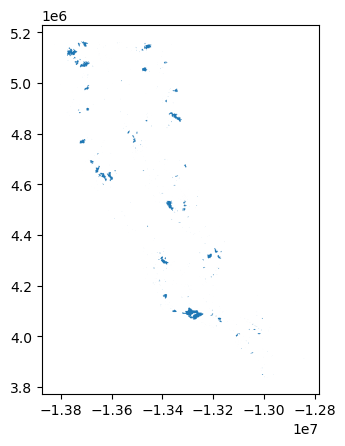

In [40]:
# plots the current data
ca_fire_perimeter_2017.plot()

### Remove bands

In [41]:
# remove band in ca_fires_band_2017

# old dimensions
print('old:', ca_fire_bands_2017.dims,'\n')

# remove length 1 dimension (band)
ca_fire_bands_2017 = ca_fire_bands_2017.squeeze()
print('band removed:', ca_fire_bands_2017.dims,'\n')

# remove coordinates associated to band
ca_fire_bands_2017 = ca_fire_bands_2017.drop('band')
print('new:', ca_fire_bands_2017.dims)

old: Frozen({'y': 731, 'x': 870, 'band': 1}) 

band removed: Frozen({'y': 731, 'x': 870}) 

new: Frozen({'y': 731, 'x': 870})


### Update Columns

In [42]:
# make columns names lower case
ca_fire_perimeter_2017.columns = ca_fire_perimeter_2017.columns.str.lower()


### Update Shapefile CRS

In [43]:
# update crs
ca_fire_perimeter_2017 = ca_fire_perimeter_2017.to_crs(ca_fire_bands_2017.rio.crs)

### Create Perimeter for Thomas Fire

In [44]:
# create perimeter for thomas fire
thomas_perimeter = ca_fire_perimeter_2017[ca_fire_perimeter_2017['fire_name']=='THOMAS']

## Map of False Color Image and Thomas Fire Perimeter

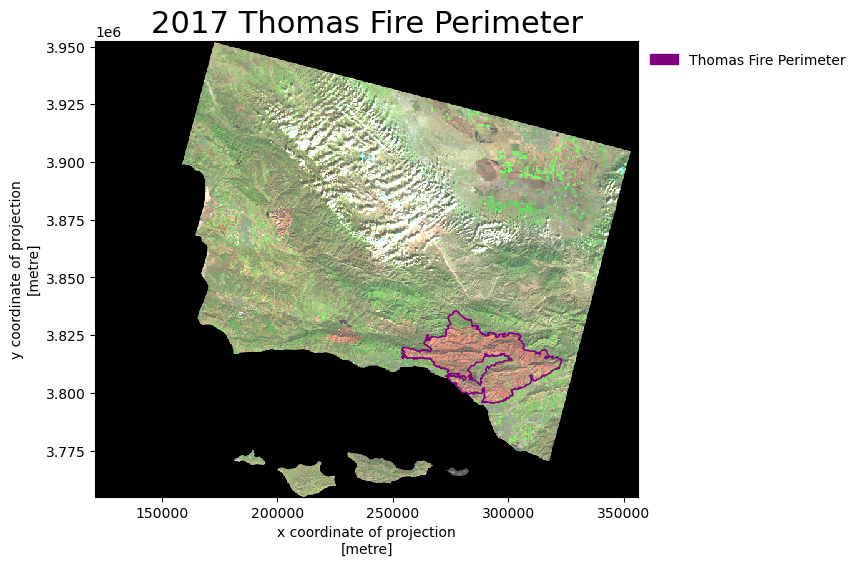

In [45]:
# creates empty plot
fig, ax = plt.subplots(figsize = (7,7))


# plot ca fire bands to use as base
ca_fire_bands_2017[['swir22', # subset for bands
                     'nir08', 
                     'red']].to_array().plot.imshow(ax = ax,
                                                    robust = True)

# plot thomas fire perimeter
thomas_perimeter.plot(ax = ax, edgecolor = "purple", color = 'none') # plot thomas_perimeter
thomas_perimeter_patches = mpatches.Patch( color = "purple", # color
                                    label = "Thomas Fire Perimeter") # label

# title
ax.set_title('2017 Thomas Fire Perimeter',
fontsize=22) # font size

# add legend
ax.legend(handles = [thomas_perimeter_patches], frameon=False, loc='upper left', bbox_to_anchor = (1, 1))

# save map into folder
plt.savefig('Air-Quality-Data-False-Color-Image/figures/thomas_fire.png', bbox_inches='tight',  dpi=50)

# Final Outputs

![](figures/aqi.png)

![](figures/thomas_fire.png)